# Metric Learning Baseline
事前学習モデルの最終層の出力(Global Pooling)を類似度検索のベクトルに利用

In [1]:
import os

from tqdm.notebook import tqdm
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
import timm
import albumentations as A
import cv2

In [2]:
img_size = 128
batch_size = 64

dataframe_image_col = 'image_id'
dataframe_label_col = 'label'

In [3]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
device

device(type='cpu')

### データ

In [4]:
!ls ../tmp/market_metriclearning_HT

images    test.csv  train.csv


In [5]:
!ls -l ../tmp/market_metriclearning_HT/images | wc -l

   12937


In [6]:
image_dir = '../tmp/market_metriclearning_HT/images'

In [7]:
df_train = pd.read_csv('../tmp/market_metriclearning_HT/train.csv')
print(df_train.shape)
df_train.head()

(12114, 3)


,image_id,label,fold
0,0517_c5s1_143520_02.jpg,517,2
1,0816_c6s2_104418_01.jpg,816,4
2,1278_c1s6_012016_02.jpg,1278,2
3,0508_c5s2_082302_02.jpg,508,1
4,1198_c6s3_034292_01.jpg,1198,3


In [8]:
df_train['label'].value_counts()[600:620]

label
433     7
1295    7
236     7
1471    7
522     7
398     7
579     7
1427    7
1464    7
1325    7
1346    7
371     7
245     7
397     7
1363    7
958     7
752     7
1316    7
604     7
940     7
Name: count, dtype: int64

In [9]:
# 上記20ラベルのデータに絞る
df_sample = df_train[df_train['label'].isin(df_train['label'].value_counts()[600:620].index)]
df_sample

,image_id,label,fold
21,1325_c3s3_036228_03.jpg,1325,3
42,1295_c1s5_057466_01.jpg,1295,3
118,0940_c3s2_118119_02.jpg,940,4
120,0604_c2s2_013662_01.jpg,604,4
168,0604_c6s2_011093_03.jpg,604,3
...,...,...,...
11047,1363_c2s3_058277_01.jpg,1363,1
11082,1316_c4s5_057510_01.jpg,1316,3
11374,0371_c1s2_015416_01.jpg,371,0
11400,0397_c1s2_021866_02.jpg,397,0


In [10]:
'''
df_test = pd.read_csv('../tmp/market_metriclearning_HT/test.csv')
print(df_test.shape)
df_test.head()
'''

"\ndf_test = pd.read_csv('../tmp/market_metriclearning_HT/test.csv')\nprint(df_test.shape)\ndf_test.head()\n"

## Augmentation, Dataset

In [11]:
transform_scoring = A.Compose([
    A.Resize(height=img_size, width=img_size, p=1),
    A.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

In [12]:
class CustomDataset(torch.utils.data.Dataset):

    def __init__(self, df, img_dir, transforms, mode='train'):
        self.df = df.reset_index(drop=True)
        self.img_dir = img_dir
        self.transforms = transforms
        self.mode = mode

    def __len__(self):
        return self.df.shape[0]

    def __getitem__(self, index):
        img_file_name = self.df.loc[index, dataframe_image_col]
        img_file_path = os.path.join(self.img_dir, img_file_name)
        target = self.df.loc[index, dataframe_label_col]
    
        image = cv2.imread(img_file_path)
        image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR)

        image_transformed = self.transforms(image=image)['image']

        image_transformed = image_transformed.astype(np.float32)
        image_transformed = image_transformed.transpose(2, 0, 1)
        #image_transformed /= 255.   # transform内で正規化するので実施なし

        if self.mode == 'inference':
            return torch.tensor(image_transformed).float()
        else:   # Train/Valid/Testなど正解ラベルが必要な時
            return torch.tensor(image_transformed).float(), torch.tensor(target).long()


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


<__main__.CustomDataset object at 0x7ff30388ecd0> 140
<class 'torch.Tensor'> <class 'torch.Tensor'>
torch.Size([3, 128, 128]) tensor(1325)


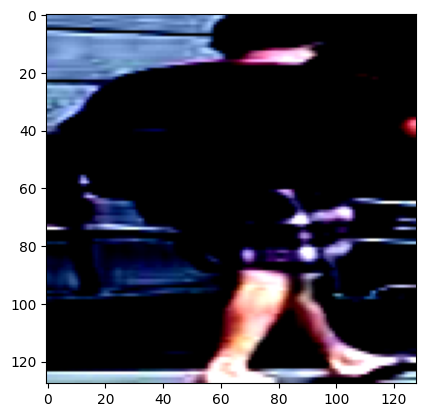

In [13]:
# Dataset test
tmp_dataset = CustomDataset(df=df_sample, img_dir=image_dir, transforms=transform_scoring, mode='train')
print(tmp_dataset, len(tmp_dataset))

tmp_img, tmp_label = tmp_dataset[0]    # 表示画像indexを指定
print(type(tmp_img), type(tmp_label))
print(tmp_img.shape, tmp_label)

plt.imshow(tmp_img.permute(1, 2, 0))
plt.show()

## Model

In [57]:
# デフォルトで読み込み
backborn = timm.create_model('resnet50', pretrained=True)
backborn.default_cfg

{'url': 'https://github.com/rwightman/pytorch-image-models/releases/download/v0.1-rsb-weights/resnet50_a1_0-14fe96d1.pth',
 'hf_hub_id': 'timm/resnet50.a1_in1k',
 'architecture': 'resnet50',
 'tag': 'a1_in1k',
 'custom_load': False,
 'input_size': (3, 224, 224),
 'test_input_size': (3, 288, 288),
 'fixed_input_size': False,
 'interpolation': 'bicubic',
 'crop_pct': 0.95,
 'test_crop_pct': 1.0,
 'crop_mode': 'center',
 'mean': (0.485, 0.456, 0.406),
 'std': (0.229, 0.224, 0.225),
 'num_classes': 1000,
 'pool_size': (7, 7),
 'first_conv': 'conv1',
 'classifier': 'fc',
 'origin_url': 'https://github.com/huggingface/pytorch-image-models',
 'paper_ids': 'arXiv:2110.00476'}

In [58]:
backborn(torch.rand(8, 3, 328, 328)).shape

torch.Size([8, 1000])

In [59]:
# 各畳み込み層の出力を取得する場合
backborn = timm.create_model('resnet50', pretrained=True, features_only=True)
backborn.default_cfg

{'url': 'https://github.com/rwightman/pytorch-image-models/releases/download/v0.1-rsb-weights/resnet50_a1_0-14fe96d1.pth',
 'hf_hub_id': 'timm/resnet50.a1_in1k',
 'architecture': 'resnet50',
 'tag': 'a1_in1k',
 'custom_load': False,
 'input_size': (3, 224, 224),
 'test_input_size': (3, 288, 288),
 'fixed_input_size': False,
 'interpolation': 'bicubic',
 'crop_pct': 0.95,
 'test_crop_pct': 1.0,
 'crop_mode': 'center',
 'mean': (0.485, 0.456, 0.406),
 'std': (0.229, 0.224, 0.225),
 'pool_size': (7, 7),
 'first_conv': 'conv1',
 'origin_url': 'https://github.com/huggingface/pytorch-image-models',
 'paper_ids': 'arXiv:2110.00476'}

In [60]:
sample_in = torch.rand(8, 3, 328, 328)

sample_out = backborn(sample_in)
print(len(sample_out))
print(sample_out[0].shape)
print(sample_out[1].shape)
print(sample_out[2].shape)
print(sample_out[3].shape)
print(sample_out[4].shape)    # 最後の畳み込み層の出力

5
torch.Size([8, 64, 164, 164])
torch.Size([8, 256, 82, 82])
torch.Size([8, 512, 41, 41])
torch.Size([8, 1024, 21, 21])
torch.Size([8, 2048, 11, 11])


### 事前学習済みモデルのGlobal Poolingの出力を利用

In [61]:
# Head部分なしでのモデル取得（Global Poolingの出力）
backborn = timm.create_model('resnet50', pretrained=True, num_classes=0)
backborn.default_cfg

{'url': 'https://github.com/rwightman/pytorch-image-models/releases/download/v0.1-rsb-weights/resnet50_a1_0-14fe96d1.pth',
 'hf_hub_id': 'timm/resnet50.a1_in1k',
 'architecture': 'resnet50',
 'tag': 'a1_in1k',
 'custom_load': False,
 'input_size': (3, 224, 224),
 'test_input_size': (3, 288, 288),
 'fixed_input_size': False,
 'interpolation': 'bicubic',
 'crop_pct': 0.95,
 'test_crop_pct': 1.0,
 'crop_mode': 'center',
 'mean': (0.485, 0.456, 0.406),
 'std': (0.229, 0.224, 0.225),
 'num_classes': 1000,
 'pool_size': (7, 7),
 'first_conv': 'conv1',
 'classifier': 'fc',
 'origin_url': 'https://github.com/huggingface/pytorch-image-models',
 'paper_ids': 'arXiv:2110.00476'}

In [62]:
backborn(torch.rand(8, 3, 328, 328)).shape
# 2028元のベクトルが出力（Resnet18だと512次元）

torch.Size([8, 2048])

## 推論

In [18]:
dataset_train = CustomDataset(df=df_sample, img_dir=image_dir, transforms=transform_scoring, mode='train')
print(dataset_train)
loader_train = torch.utils.data.DataLoader(dataset_train, batch_size=batch_size, shuffle=False)
print(loader_train)

In [19]:
OUTPUTS, TARGETS = [], []
bar = tqdm(loader_train)
backborn = backborn.to(device)
backborn.eval()

with torch.no_grad():
        for i, (images, targets) in enumerate(bar):    # バッチループ
            images = images.to(device)
            targets = targets.to(device)
            outputs = backborn(images)
            
            OUTPUTS.append(outputs.cpu().numpy())
            TARGETS.append(targets.cpu().numpy())

OUTPUTS = np.concatenate(OUTPUTS)
TARGETS = np.concatenate(TARGETS)

  0%|          | 0/3 [00:00<?, ?it/s]

In [20]:
OUTPUTS.shape, TARGETS.shape

((140, 2048), (140,))

In [21]:
df_sample_res = df_sample.copy()
df_sample_res['img_vec'] = [v for v in OUTPUTS]
#df_sample_res['target'] =  = [t for t in TARGETS]    # TARGETSはdf_sample['label']と同じ

In [22]:
df_sample_res

,image_id,label,fold,img_vec
21,1325_c3s3_036228_03.jpg,1325,3,"[0.00769224, 0.0, 0.0, 0.00753034, 0.37705994,..."
42,1295_c1s5_057466_01.jpg,1295,3,"[1.06333755e-05, 0.017068844, 0.19213721, 0.0,..."
118,0940_c3s2_118119_02.jpg,940,4,"[0.0, 0.14982554, 0.040754497, 0.012328578, 0...."
120,0604_c2s2_013662_01.jpg,604,4,"[0.0, 0.0, 0.0003642738, 0.0, 1.1227812, 0.0, ..."
168,0604_c6s2_011093_03.jpg,604,3,"[0.0, 0.008828372, 0.0, 0.0, 0.5864254, 0.0863..."
...,...,...,...,...
11047,1363_c2s3_058277_01.jpg,1363,1,"[0.0, 0.0, 0.0, 0.0150524005, 0.64806867, 0.0,..."
11082,1316_c4s5_057510_01.jpg,1316,3,"[0.0, 0.2788849, 0.0, 0.0, 0.13455302, 0.01168..."
11374,0371_c1s2_015416_01.jpg,371,0,"[0.0, 0.07788111, 0.0, 0.54350704, 0.47287163,..."
11400,0397_c1s2_021866_02.jpg,397,0,"[0.0, 0.0, 0.0, 0.024373747, 1.2411304, 0.0330..."


In [23]:
df_sample_res = df_sample_res.sort_values('label')
df_sample_res = df_sample_res.reset_index(drop=True)
df_sample_res

,image_id,label,fold,img_vec
0,0236_c3s1_049026_03.jpg,236,1,"[0.0, 0.0, 0.0, 0.0, 0.09524873, 0.0021669231,..."
1,0236_c6s1_049551_01.jpg,236,3,"[0.0, 0.0, 0.0, 0.0, 1.453228, 0.0, 0.47155687..."
2,0236_c3s1_048926_01.jpg,236,0,"[0.0, 0.0, 0.06292614, 0.003400892, 0.2905464,..."
3,0236_c2s1_048826_01.jpg,236,2,"[0.0, 0.0, 0.18484941, 0.0, 0.7985055, 0.0, 0...."
4,0236_c6s1_049576_02.jpg,236,4,"[0.0, 0.0, 0.0, 0.0, 1.2596354, 0.0, 0.0653634..."
...,...,...,...,...
135,1471_c2s3_053882_02.jpg,1471,4,"[0.0, 0.0, 0.0, 0.009950232, 1.3554841, 0.0, 0..."
136,1471_c3s3_060228_03.jpg,1471,3,"[0.0, 0.0, 0.0, 0.0, 0.87798095, 0.0, 0.367295..."
137,1471_c6s3_083942_03.jpg,1471,2,"[0.0, 0.0008057151, 0.0, 0.0, 1.2398798, 0.0, ..."
138,1471_c6s3_083992_01.jpg,1471,3,"[0.0, 0.0, 0.0, 0.0, 1.4635046, 0.0, 0.4344229..."


In [24]:
type(df_sample_res.loc[0, 'img_vec'])

numpy.ndarray

In [25]:
df_sample_res['label'].value_counts()

label
236     7
245     7
1464    7
1427    7
1363    7
1346    7
1325    7
1316    7
1295    7
958     7
940     7
752     7
604     7
579     7
522     7
433     7
398     7
397     7
371     7
1471    7
Name: count, dtype: int64

## 可視化（UMAP）

UMAP
- https://github.com/lmcinnes/umap
- https://umap-learn.readthedocs.io/en/latest/index.html

## 画像間類似度

https://kevinmusgrave.github.io/pytorch-metric-learning/distances/#cosinesimilarity
使える？

In [26]:
# 各ベクトルの平均と標準偏差を計算

f = lambda x: np.mean(x)
df_sample_res['img_vec_mean'] = df_sample_res['img_vec'].apply(f)

f = lambda x: np.std(x)
df_sample_res['img_vec_std'] = df_sample_res['img_vec'].apply(f)

In [27]:
df_sample_res

,image_id,label,fold,img_vec,img_vec_mean,img_vec_std
0,0236_c3s1_049026_03.jpg,236,1,"[0.0, 0.0, 0.0, 0.0, 0.09524873, 0.0021669231,...",0.100739,0.297026
1,0236_c6s1_049551_01.jpg,236,3,"[0.0, 0.0, 0.0, 0.0, 1.453228, 0.0, 0.47155687...",0.088154,0.255020
2,0236_c3s1_048926_01.jpg,236,0,"[0.0, 0.0, 0.06292614, 0.003400892, 0.2905464,...",0.099192,0.269711
3,0236_c2s1_048826_01.jpg,236,2,"[0.0, 0.0, 0.18484941, 0.0, 0.7985055, 0.0, 0....",0.083081,0.251942
4,0236_c6s1_049576_02.jpg,236,4,"[0.0, 0.0, 0.0, 0.0, 1.2596354, 0.0, 0.0653634...",0.064458,0.217734
...,...,...,...,...,...,...
135,1471_c2s3_053882_02.jpg,1471,4,"[0.0, 0.0, 0.0, 0.009950232, 1.3554841, 0.0, 0...",0.104793,0.296443
136,1471_c3s3_060228_03.jpg,1471,3,"[0.0, 0.0, 0.0, 0.0, 0.87798095, 0.0, 0.367295...",0.091104,0.275628
137,1471_c6s3_083942_03.jpg,1471,2,"[0.0, 0.0008057151, 0.0, 0.0, 1.2398798, 0.0, ...",0.082721,0.247744
138,1471_c6s3_083992_01.jpg,1471,3,"[0.0, 0.0, 0.0, 0.0, 1.4635046, 0.0, 0.4344229...",0.088058,0.256290


In [28]:
df_sample_res[['img_vec_mean', 'img_vec_std']].describe()

,img_vec_mean,img_vec_std
count,140.000000,140.000000
mean,0.093154,0.273641
std,0.013434,0.025703
min,0.055651,0.211463
25%,0.083442,0.255408
50%,0.093029,0.273552
75%,0.102536,0.292944
max,0.124447,0.337054


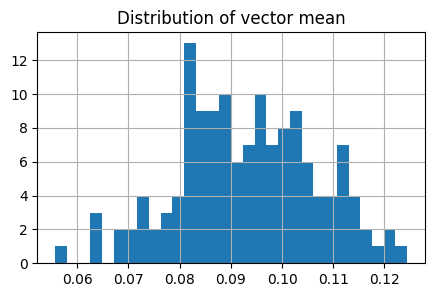

In [29]:
plt.figure(figsize=[5,3])
df_sample_res['img_vec_mean'].hist(bins=30)
plt.title('Distribution of vector mean')
plt.show()

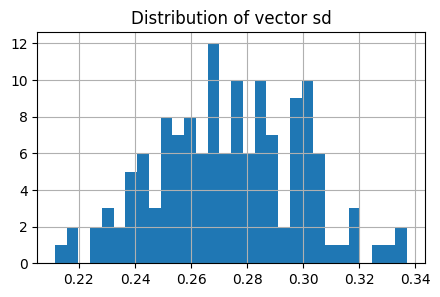

In [30]:
plt.figure(figsize=[5,3])
df_sample_res['img_vec_std'].hist(bins=30)
plt.title('Distribution of vector sd')
plt.show()

In [31]:
def cos_sim(v1, v2):
    return np.dot(v1, v2) / (np.linalg.norm(v1) * np.linalg.norm(v2))

In [32]:
# 同じラベル間の類似度
cos_sim(df_sample_res.loc[0,'img_vec'], df_sample_res.loc[1,'img_vec'])

0.6919368

In [33]:
# 同じベクトル間の類似度
cos_sim(df_sample_res.loc[0,'img_vec'], df_sample_res.loc[0,'img_vec'])

1.0

In [34]:
# 異なったラベル間の類似度
cos_sim(df_sample_res.loc[0,'img_vec'], df_sample_res.loc[40,'img_vec'])

0.742809

In [35]:
df_sample_res.head()

,image_id,label,fold,img_vec,img_vec_mean,img_vec_std
0,0236_c3s1_049026_03.jpg,236,1,"[0.0, 0.0, 0.0, 0.0, 0.09524873, 0.0021669231,...",0.100739,0.297026
1,0236_c6s1_049551_01.jpg,236,3,"[0.0, 0.0, 0.0, 0.0, 1.453228, 0.0, 0.47155687...",0.088154,0.255020
2,0236_c3s1_048926_01.jpg,236,0,"[0.0, 0.0, 0.06292614, 0.003400892, 0.2905464,...",0.099192,0.269711
3,0236_c2s1_048826_01.jpg,236,2,"[0.0, 0.0, 0.18484941, 0.0, 0.7985055, 0.0, 0....",0.083081,0.251942
4,0236_c6s1_049576_02.jpg,236,4,"[0.0, 0.0, 0.0, 0.0, 1.2596354, 0.0, 0.0653634...",0.064458,0.217734


In [43]:
# あるベクトルと各々の類似度
idx = 25   # 画像Index番号
base_vac = df_sample_res.loc[idx,'img_vec']

f = lambda x: cos_sim(base_vac, x)
similarity = df_sample_res['img_vec'].apply(f)

In [44]:
similarity

0      0.508710
1      0.609589
2      0.387135
3      0.572665
4      0.466249
         ...   
135    0.701154
136    0.668241
137    0.603473
138    0.679842
139    0.604891
Name: img_vec, Length: 140, dtype: float32

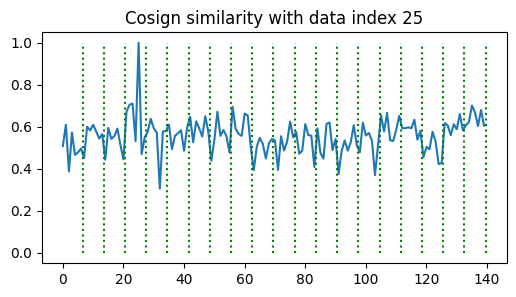

In [45]:
plt.figure(figsize=[6,3])
plt.plot(similarity)
plt.title(f'Cosign similarity with data index {idx}')
v_lines = [6.5+i*7 for i in range(df_sample_res['label'].nunique())]
for l in v_lines:
    plt.vlines(l, 0, 1, color='g', linestyles='dotted')

# 縦線間が同じラベル